In [2]:
# Imports & helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set(style="whitegrid")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def print_reg_metrics(y_true, y_pred, prefix=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MSE: {mse:.4f}  RMSE: {rmse:.4f}  MAE: {mae:.4f}  R2: {r2:.4f}")
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

In [5]:
# Load banknote dataset
try:
    bnote = pd.read_csv("Banknote_Authentication.csv")
except FileNotFoundError:
        print("Banknote dataset file not found. Please place data_banknote.csv or data_banknote_authentication.txt into working directory.")
        bnote = None

if bnote is not None:
    print("Shape:", bnote.shape)
    display(bnote.head())

    # If unnamed columns, set names
    if bnote.shape[1] == 5 and list(bnote.columns) == [0,1,2,3,4]:
        bnote.columns = ['var1','var2','var3','var4','class']
    
    # Basic split
    Xb = bnote.drop(columns=['class']).values
    yb = bnote['class'].values
    Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=RANDOM_SEED, stratify=yb)
    print("Train size:", Xb_train.shape)
    print("Test size:", Xb_test.shape)


Shape: (1372, 5)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Train size: (1097, 4)
Test size: (275, 4)


In [6]:
# Logistic regression with and without L2
if bnote is not None:
    scaler_b = StandardScaler()
    Xb_train_std = scaler_b.fit_transform(Xb_train)
    Xb_test_std = scaler_b.transform(Xb_test)

    # Without regularization (use very large C in sklearn to approximate no reg)
    clf_no_reg = LogisticRegression(penalty='none', solver='saga', max_iter=5000, random_state=RANDOM_SEED)
    # Some sklearn versions require penalty='none'; others may not support 'none'. Fallback:
    try:
        clf_no_reg.fit(Xb_train_std, yb_train)
    except Exception:
        clf_no_reg = LogisticRegression(C=1e12, penalty='l2', solver='lbfgs', max_iter=5000)
        clf_no_reg.fit(Xb_train_std, yb_train)
        print("Penalty='none' unsupported; used very large C to mimic no regularization.")

    acc_train_no = clf_no_reg.score(Xb_train_std, yb_train)
    acc_test_no = clf_no_reg.score(Xb_test_std, yb_test)
    print(f"No-regularization train acc: {acc_train_no:.4f}  test acc: {acc_test_no:.4f}")

    # With L2 regularization (default in sklearn)
    clf_l2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=5000, random_state=RANDOM_SEED)
    clf_l2.fit(Xb_train_std, yb_train)
    acc_train_l2 = clf_l2.score(Xb_train_std, yb_train)
    acc_test_l2 = clf_l2.score(Xb_test_std, yb_test)
    print(f"L2 (C=1.0) train acc: {acc_train_l2:.4f}  test acc: {acc_test_l2:.4f}")


Penalty='none' unsupported; used very large C to mimic no regularization.
No-regularization train acc: 0.9909  test acc: 0.9855
L2 (C=1.0) train acc: 0.9845  test acc: 0.9709


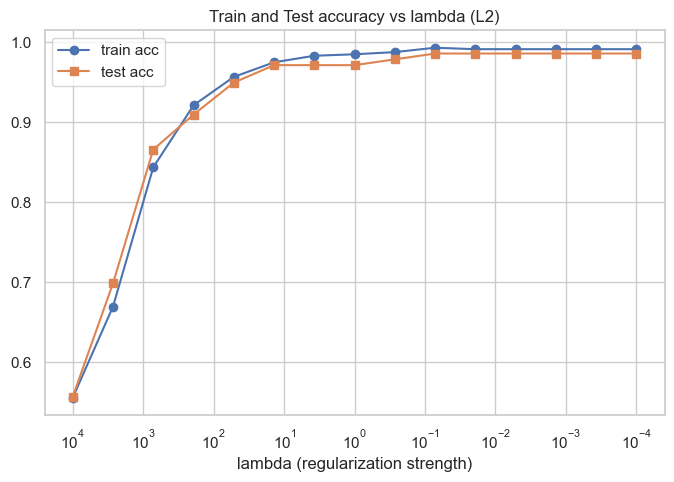

In [7]:
# Sweep lambda and plot accuracies
if bnote is not None:
    lambdas = np.logspace(-4, 4, 15)  # λ values
    train_accs = []
    test_accs = []
    for lam in lambdas:
        C = 1.0 / lam if lam != 0 else 1e12
        clf = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=5000)
        clf.fit(Xb_train_std, yb_train)
        train_accs.append(clf.score(Xb_train_std, yb_train))
        test_accs.append(clf.score(Xb_test_std, yb_test))

    plt.figure(figsize=(8,5))
    plt.semilogx(lambdas, train_accs, marker='o', label='train acc')
    plt.semilogx(lambdas, test_accs, marker='s', label='test acc')
    plt.xlabel("lambda (regularization strength)")
    plt.xscale('log')
    plt.gca().invert_xaxis() # because lambda increases left->right on log axis; optional
    plt.title("Train and Test accuracy vs lambda (L2)")
    plt.legend()
    plt.show()


Top 3 features: ['var2', 'var1', 'var3']


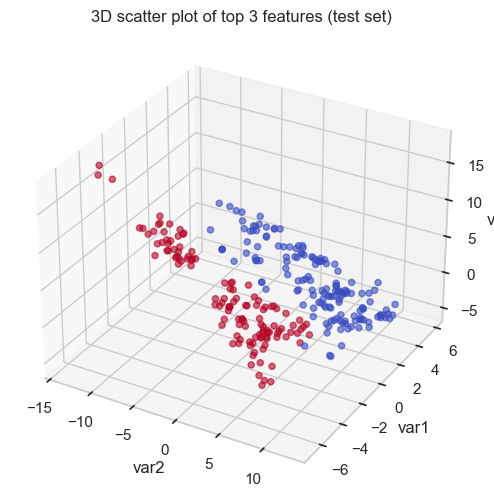

In [8]:
# 3D plot using three most important features by logistic absolute weight magnitudes
if bnote is not None:
    coefs = np.abs(clf_l2.coef_.flatten())
    feat_names = ['var1','var2','var3','var4'] if len(Xb.shape)>1 else [f'v{i}' for i in range(Xb.shape[1])]
    feat_importance = pd.DataFrame({"feature": feat_names, "abs_coef": coefs}).sort_values('abs_coef', ascending=False)
    top3 = feat_importance['feature'].values[:3].tolist()
    print("Top 3 features:", top3)

    # indices
    idxs = [feat_names.index(f) for f in top3]
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xb_test[:, idxs[0]], Xb_test[:, idxs[1]], Xb_test[:, idxs[2]], c=yb_test, cmap='coolwarm', alpha=0.6)
    ax.set_xlabel(top3[0]); ax.set_ylabel(top3[1]); ax.set_zlabel(top3[2])
    plt.title("3D scatter plot of top 3 features (test set)")
    plt.show()


In [9]:
# Inject outliers (shift a small fraction of points) and retrain
if bnote is not None:
    X_out = Xb_train_std.copy()
    y_out = yb_train.copy()
    n_outliers = max(1, int(0.05 * X_out.shape[0]))  # 5% outliers
    # pick random indices to perturb
    rng = np.random.default_rng(RANDOM_SEED)
    idxs = rng.choice(X_out.shape[0], size=n_outliers, replace=False)
    # shift feature values by a large factor for selected points
    X_out[idxs] = X_out[idxs] + 8.0 * np.sign(np.random.randn(*X_out[idxs].shape))

    # Train classifier on outlier-injected data
    clf_out = LogisticRegression(penalty='l2', C=1.0, max_iter=5000)
    clf_out.fit(X_out, y_out)
    acc_train_out = clf_out.score(X_out, y_out)
    acc_test_out = clf_out.score(Xb_test_std, yb_test)
    print(f"With outliers - train acc: {acc_train_out:.4f}, test acc: {acc_test_out:.4f}")

    # Compare to original
    print(f"Original (no outliers) - train acc: {acc_train_l2:.4f}, test acc: {acc_test_l2:.4f}")


With outliers - train acc: 0.9417, test acc: 0.9564
Original (no outliers) - train acc: 0.9845, test acc: 0.9709


In [10]:
# Print short summary
if bnote is not None:
    print("Commentary:")
    print(" - If test accuracy drops after injecting outliers, the classifier is sensitive to outliers.")
    print(" - L2 regularization helps reduce overfitting and can somewhat mitigate outlier effects by shrinking weights.")
    print(" - For strong robustness to outliers, consider robust methods (e.g., robust scaling, RANSAC, Huber loss, or tree-based models).")


Commentary:
 - If test accuracy drops after injecting outliers, the classifier is sensitive to outliers.
 - L2 regularization helps reduce overfitting and can somewhat mitigate outlier effects by shrinking weights.
 - For strong robustness to outliers, consider robust methods (e.g., robust scaling, RANSAC, Huber loss, or tree-based models).
